## Gender in a million headlines

**What can headlines from the Australian national broadcaster (the ABC) </br>
tell us about the concerns of the Australian public over time, where those </br>
concerns relate to male and/or female persons?**

In [99]:
from FileTools import FileTools
from collections import Counter
import pandas as pd
import nltk
import os

# import time  # remove after testing

# import numpy as np

import matplotlib.pyplot as plt

# import seaborn as sns
# import re

### Data acquisition, cleaning and feature engineering

In [4]:
# authenticate and load kaggle dataset (github.com/romstroller/FileTools)
fTools = FileTools()
dfOrig = fTools.getKaggleSet( 'therohk', 'million-headlines' )
dfOrig

Waiting for dataset download
Latest: million-headlines.zip
Got DF from extracted dSet at:
 C:\Users\romstroller\PYC\pythonProject3\data_or\abcnews-date-text.csv


,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers
...,...,...
1244179,20211231,two aged care residents die as state records 2...
1244180,20211231,victoria records 5;919 new cases and seven deaths
1244181,20211231,wa delays adopting new close contact definition
1244182,20211231,western ringtail possums found badly dehydrate...


The most flexible / granular set of data would be a list comprised of all </br>
the words in all headlines, each paired to the date of the headline in </br>
which they featured.

In [8]:
# split headlines into word-by-date
df = pd.DataFrame( dfOrig.headline_text.str.split( ' ' ).tolist(),
    index=dfOrig.publish_date ).stack().reset_index( inplace=False )
df.rename( columns={ 0: 'word', 'publish_date': 'date' }, inplace=True )
del df[ 'level_1' ]
df

,date,word
0,20030219,aba
1,20030219,decides
2,20030219,against
3,20030219,community
4,20030219,broadcasting
...,...,...
8158762,20211231,here
8158763,20211231,are
8158764,20211231,the
8158765,20211231,new


#### Assumptions and definitions

It is important to point out that there is no guaranteed metric available
for the "concerns" of an audience, unless a profoundly narrowed definition
for concern is approximated using, for example, a set of behavioural indicators.

In the limitations of this dataset, we will need to equate "concern" with the
prominence of particular patterns of reference. This speaks more directly to the 
"concern" of ABC-published journalism. 

To conduct the project, we make the assumption that public concern may be 
estimated by the frequency of words in a headline ("headwords") that appear 
together in a manner indicating uniform objects of communication. 

*Concern* is thus "headword frequency", or headword-count-at-date.

##### GENDER KEYWORDS

More specifically, gendered individuals as objects of communication will be 
estimated to occur, **in a set where non-gendered stopwords are omitted**,

###### VARIANT ONE (drafted):
- for males, equally with "man" and "men", and for females, likewise with "woman" 
and "women".

###### VARIANT TWO (extend):
- Include "male", "males", "man", "men, "female", "females", "woman", "women"
- "boys", "boy", "girl", "girls"
- NORMALIZE CAPITALIZATION
- "for males, equally for occurances of "he", "him", "his", "himself" ( and 
common syntactical variations like "he's" and "he'd" ) and equivalently for 
females with "she", "her", "hers", "herself"."

**run word count for initial indicators**

In [23]:
# testing counter
wordcount = Counter( df[ 'word' ].tolist() )
wordcount.most_common()[ :25 ]

[('to', 238375),
 ('in', 156175),
 ('for', 143272),
 ('of', 95940),
 ('on', 82014),
 ('the', 65048),
 ('over', 54527),
 ('police', 39813),
 ('at', 36887),
 ('with', 36331),
 ('after', 34641),
 ('new', 33729),
 ('a', 31148),
 ('man', 30627),
 ('and', 30069),
 ('as', 24333),
 ('says', 23731),
 ('from', 23440),
 ('up', 22872),
 ('by', 21375),
 ('us', 20370),
 ('out', 19117),
 ('be', 18199),
 ('court', 18180),
 ('govt', 17091)]

In [29]:
nltk.download( 'stopwords', download_dir=os.getcwd() )

with open( "corpora\stopwords\english", 'r' ) as f:
    stopwords = [ line.strip() for line in f ]

# stopwords includes:
#      'he',
#      'him',
#      'his',
#      'himself',
#      'she',
#      "she's",
#      'her',
#      'hers',
#      'herself',

stopwordsV1 = [ w for w in stopwords if w not in [
    "man", "men", "woman", "women" ] ]

dfNonStopV1 = df[ ~df[ 'word' ].isin( stopwordsV1 ) ]

# re-testing counter
wordcount = Counter( dfNonStopV1[ 'word' ].tolist() )
wdCountSt = wordcount.most_common()
wdCountSt[ :25 ]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\romstroller\PYC\pythonProject3...
[nltk_data]   Package stopwords is already up-to-date!


[('police', 39813),
 ('new', 33729),
 ('man', 30627),
 ('says', 23731),
 ('us', 20370),
 ('court', 18180),
 ('govt', 17091),
 ('australia', 17071),
 ('council', 16955),
 ('nsw', 16516),
 ('fire', 15512),
 ('interview', 15426),
 ('australian', 13632),
 ('wa', 13464),
 ('sydney', 13065),
 ('plan', 12993),
 ('water', 12850),
 ('death', 12749),
 ('qld', 12590),
 ('crash', 12356),
 ('health', 11967),
 ('back', 11221),
 ('charged', 11193),
 ('murder', 10529),
 ('report', 10413)]

#### Initial observations

A glaring insight for our objective is already available at this point:
*man* is the third-most common word altogether, gendered or otherwise, in 
this cleaned dataset, while none of our female headwords are even in the 
top 25. How are the female headwords ranked?

In [41]:
print( [ f"pos {i}: {x[ 0 ]} (cnt {x[ 1 ]})" for i, x in enumerate( wdCountSt )
    if x[ 0 ] in [ "man", "men", "woman", "women" ] ] )

['pos 2: man (cnt 30627)', 'pos 36: woman (cnt 9463)', 'pos 245: women (cnt 3867)', 'pos 320: men (cnt 3160)']


"Woman" doesn't get in the ranking until 37th, and over three times 
less-frequently than "man". Somewhat interestingly, "women" then appears at 
246th, some ways above "men" at 321th. In the simplistic limitations of our 
analysis, if a group of gendered people is of concern, it is more likely to be 
of women, while if a gendered individual is of concern, it is more likely to be 
a man. 

In [101]:
# produce dfs grouping monthly counts for each gender headword set 
genDfs = [ ]
for gdr in [ [ "man", "men" ], [ "woman", "women" ] ]:
    gDf = pd.concat( [
        dfNonStopV1[ dfNonStopV1.word == gdr[ 0 ] ],
        dfNonStopV1[ dfNonStopV1.word == gdr[ 1 ] ]
        ], axis=0 ).sort_values( by=[ 'date' ], ascending=True )
    gDf[ 'date' ] = gDf[ 'date' ].astype( str ).str[ :6 ]  # by month; disab for linegr?
    gDf = gDf.groupby( 'date' ).size().reset_index( name='count' )
    genDfs.append( gDf )

menDf, femDf = genDfs


## Visualisation

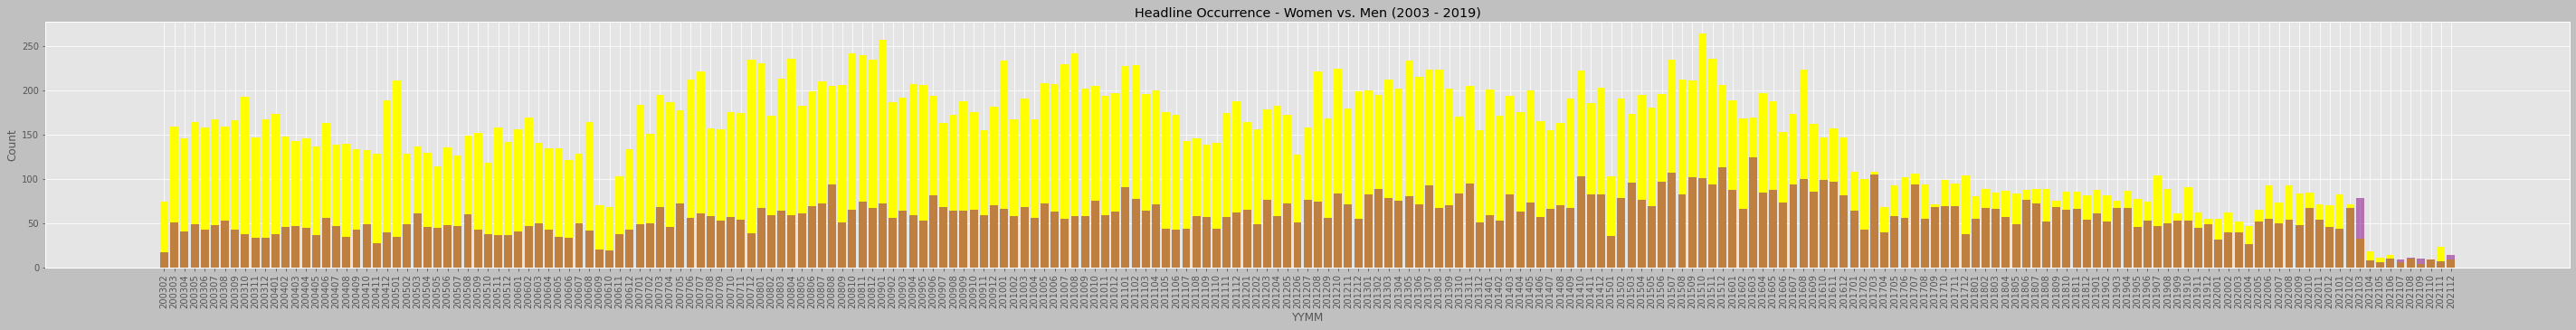

In [114]:
plt.style.use( 'ggplot' )
plt.figure( figsize=(50, 5), facecolor="silver" )

x = menDf[ 'date' ]
x_pos = [ i for i, _ in enumerate( x ) ]

countman, countwom = menDf[ 'count' ], femDf[ 'count' ]
plt.bar( x_pos, countman, color='yellow', label='Man / Men' )
plt.bar( x_pos, countwom, color='purple', alpha=0.5, label='Woman / Women' )

plt.xlabel( "YYMM" )
plt.ylabel( "Count" )
plt.title( "Headline Occurrence - Women vs. Men (2003 - 2019)" )
plt.xticks( x_pos, x )
plt.xticks( rotation=90 )

plt.savefig('Gendered_headword_prominence.png', bbox_inches='tight')
plt.show()



## Interpretation

#### Summary observations

- Men are always mentioned more often than women; there is not one month when 
this is otherwise.
- Women begin in 2003 being mentioned consistently around 1/5 - 1/4 as often as 
men are
- At around the beginning of 2013, women are being mentioned consistenly around 
half as often as men. 
- From the beginning of 2017, women begin to draw close to parity with men, 
ending at around 4/5 the mention rate of men.
- That this convergence is largely a result of the words "men" and "man" being 
used less, rather than "woman" and "women" being used more
- The closest month to parity, March 2017, coincides near International Women's 
Day on the 8th.
## trend breaks 202103

**Key interpretation: the public concern for stories dominated by either gender 
in particular as drawn significantly close to parity in recent years, while 
women remain consistently less in-focus than men.**